# ABS Quarterly National Accounts 5206

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Python-set-up" data-toc-modified-id="Python-set-up-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Python set-up</a></span></li><li><span><a href="#Get-data-from-ABS" data-toc-modified-id="Get-data-from-ABS-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Get data from ABS</a></span></li><li><span><a href="#Plot" data-toc-modified-id="Plot-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Plot</a></span><ul class="toc-item"><li><span><a href="#Growth-charts---based-on-seasonally-adjusted-series" data-toc-modified-id="Growth-charts---based-on-seasonally-adjusted-series-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Growth charts - based on seasonally adjusted series</a></span></li><li><span><a href="#Long-run-annual-GDP-Growth---using-a-Henderson-moving-average" data-toc-modified-id="Long-run-annual-GDP-Growth---using-a-Henderson-moving-average-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Long run annual GDP Growth - using a Henderson moving average</a></span></li><li><span><a href="#Four-quarter-rolling-totals---original-series" data-toc-modified-id="Four-quarter-rolling-totals---original-series-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Four quarter rolling totals - original series</a></span></li><li><span><a href="#Savings" data-toc-modified-id="Savings-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Savings</a></span></li><li><span><a href="#Gross-Value-Added-(GVA)-by-Industry" data-toc-modified-id="Gross-Value-Added-(GVA)-by-Industry-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Gross Value Added (GVA) by Industry</a></span></li><li><span><a href="#Household-Final-Consumption-Expenditure" data-toc-modified-id="Household-Final-Consumption-Expenditure-3.6"><span class="toc-item-num">3.6&nbsp;&nbsp;</span>Household Final Consumption Expenditure</a></span></li><li><span><a href="#Taxes" data-toc-modified-id="Taxes-3.7"><span class="toc-item-num">3.7&nbsp;&nbsp;</span>Taxes</a></span></li><li><span><a href="#Government-Benefits-Payments" data-toc-modified-id="Government-Benefits-Payments-3.8"><span class="toc-item-num">3.8&nbsp;&nbsp;</span>Government Benefits Payments</a></span></li><li><span><a href="#Implicit-price-deflators" data-toc-modified-id="Implicit-price-deflators-3.9"><span class="toc-item-num">3.9&nbsp;&nbsp;</span>Implicit price deflators</a></span></li></ul></li><li><span><a href="#Save-nominal-GDP-(it-is-useful-elsewhere)" data-toc-modified-id="Save-nominal-GDP-(it-is-useful-elsewhere)-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Save nominal GDP (it is useful elsewhere)</a></span></li><li><span><a href="#Finished" data-toc-modified-id="Finished-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Finished</a></span></li></ul></div>

## Python set-up

In [1]:
# system imports
import pathlib  
import calendar
import re

# analytic imports
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# local imports
from henderson import HMA
from finalise_plot import finalise_plot
from abs_common import (
    get_fs_constants,
    get_plot_constants,
    get_ABS_meta_and_data,
    get_identifier,
    find_id,
    plot_Qgrowth,
    recalibrate_series,
    clear_chart_dir,
    plot_covid_recovery,
)

# pandas display settings
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

# plotting stuff
plt.style.use('fivethirtyeight')

In [2]:
catalogue_id = '5206'
source, CHART_DIR, META_DATA = get_fs_constants(catalogue_id)
clear_chart_dir(CHART_DIR)

## Get data from ABS

In [3]:
abs_dict = get_ABS_meta_and_data(catalogue_id)
if abs_dict is None:
    sys.exit(-1)

Found URL for a ZIP file on ABS web page
Cache looks stale: Removing old cache version
We need to download this file from the ABS ...
Saving ABS download to cache.
Extracting DataFrames from the zip-file ...


In [4]:
# extract meta data, etc.
meta = abs_dict[META_DATA]
RECENT, plot_times, plot_tags = get_plot_constants(meta)
CVM = 'Chain volume measures'
value_text = '$ Millions'

# some useful columns in the meta data
table_col = 'Table'
did_col = 'Data Item Description'
type_col = 'Series Type'
unit_col = 'Unit'

## Plot

### Growth charts - based on seasonally adjusted series

Gross domestic product:


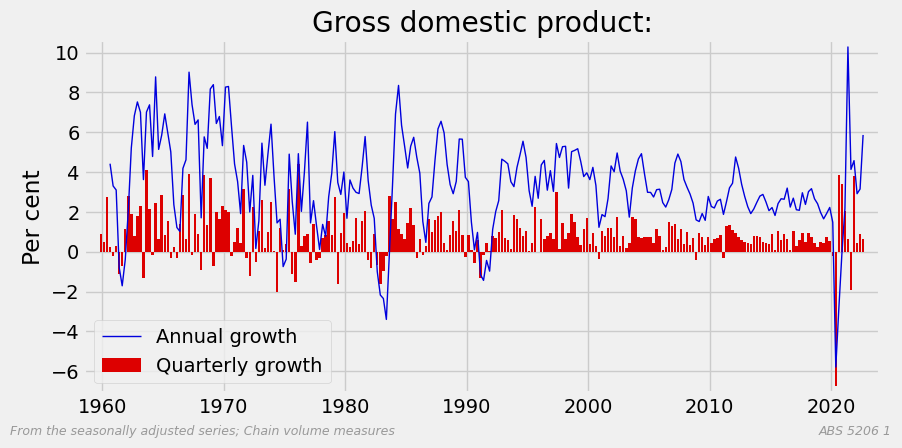

Gross domestic product:


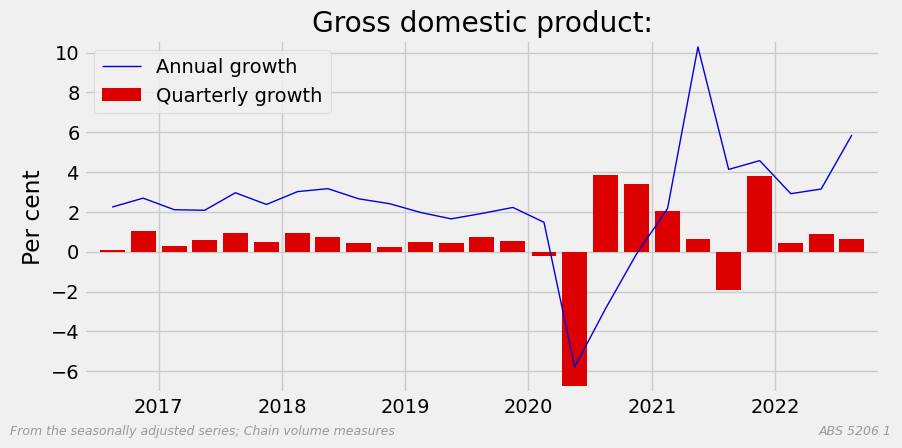

Gross value added market sector:


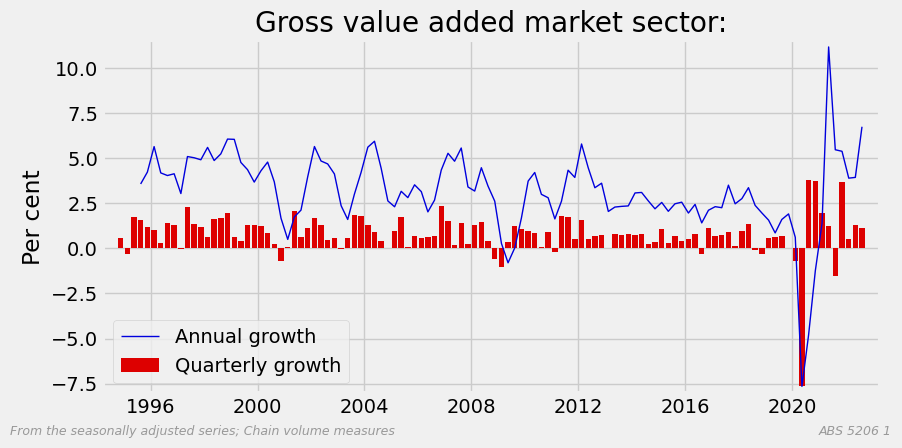

Gross value added market sector:


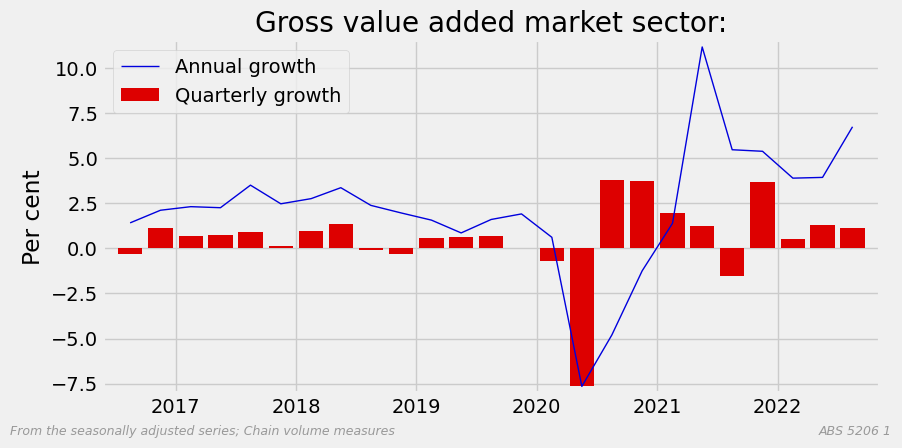

Net domestic product:


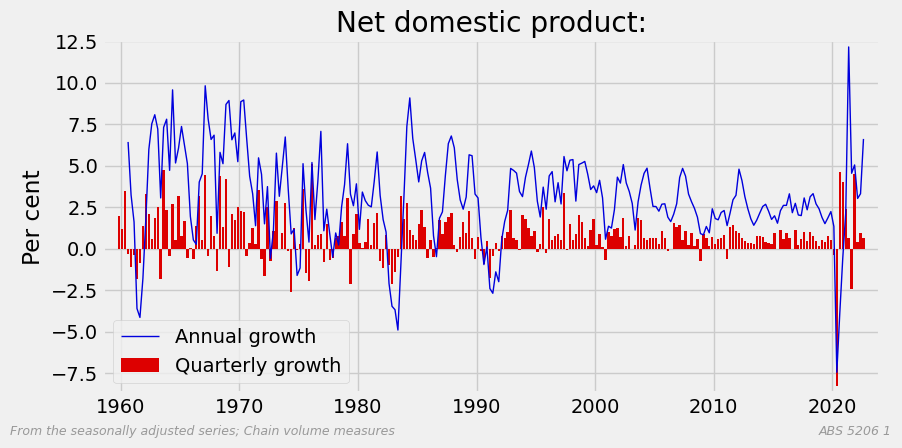

Net domestic product:


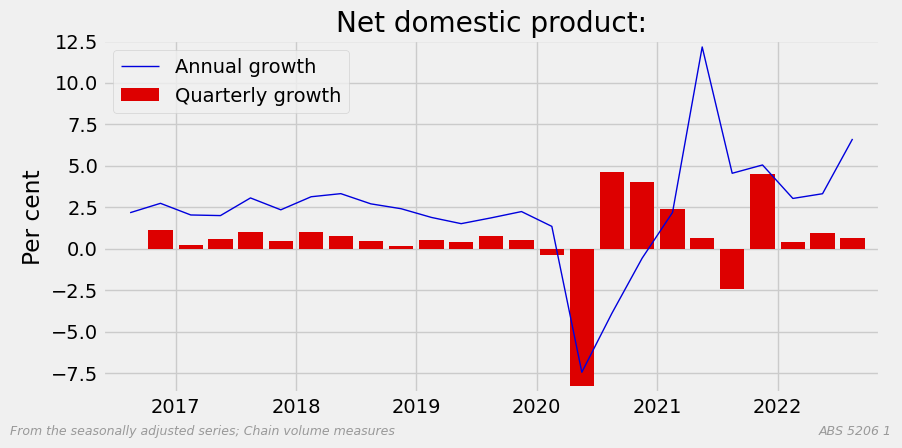

Real gross domestic income:


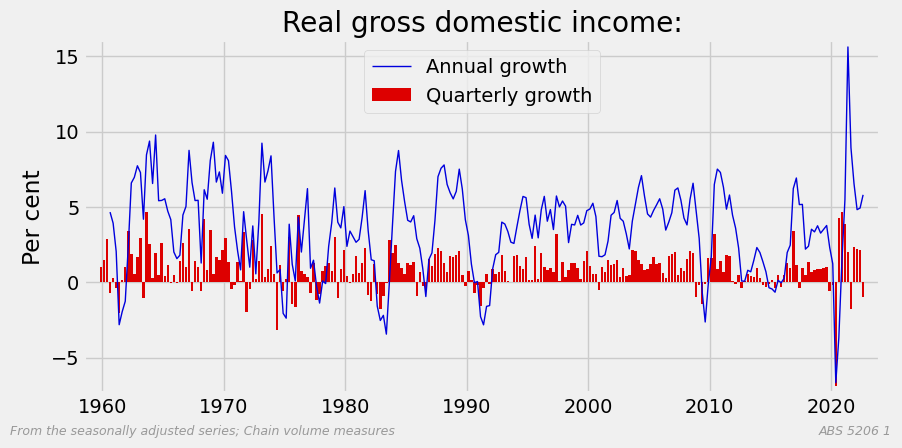

Real gross domestic income:


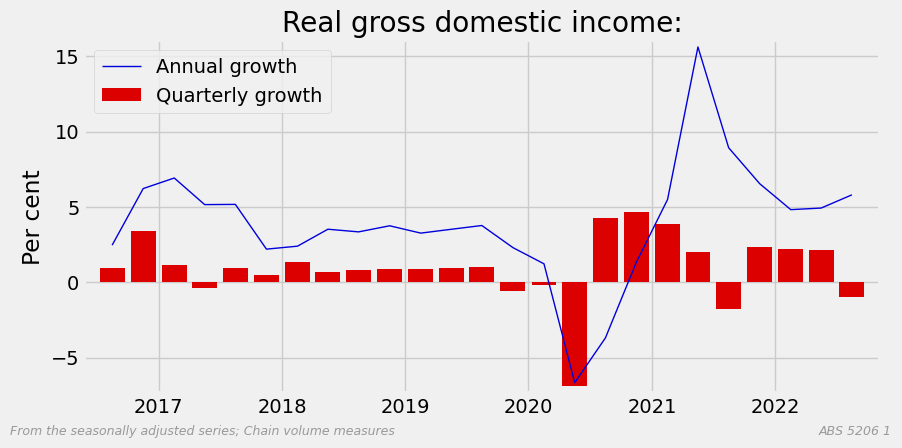

Real gross national income:


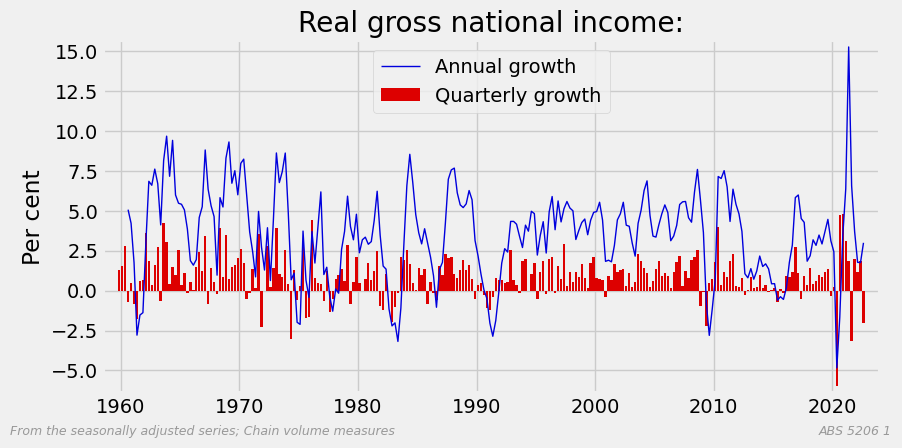

Real gross national income:


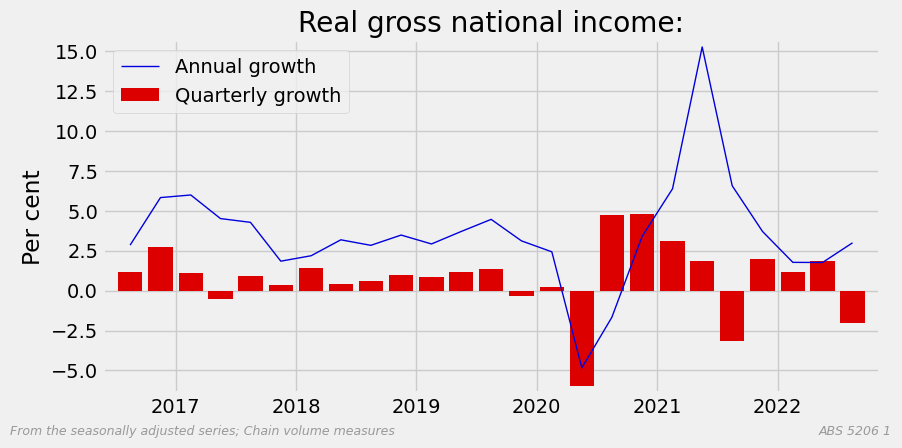

Real net national disposable income:


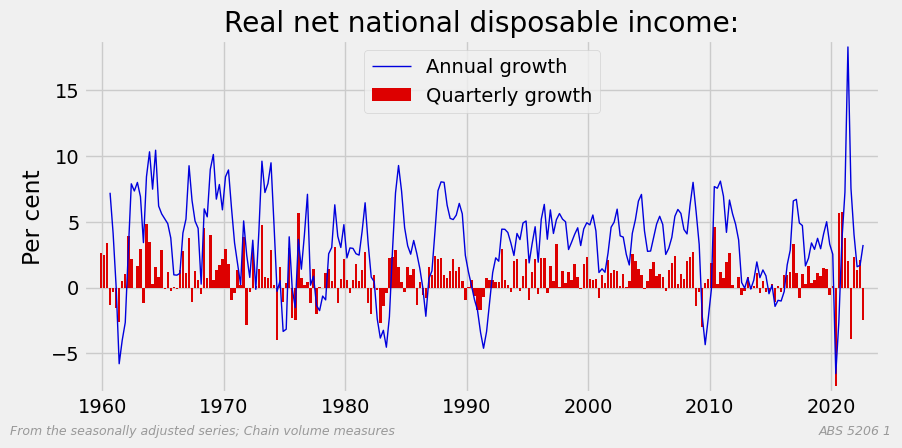

Real net national disposable income:


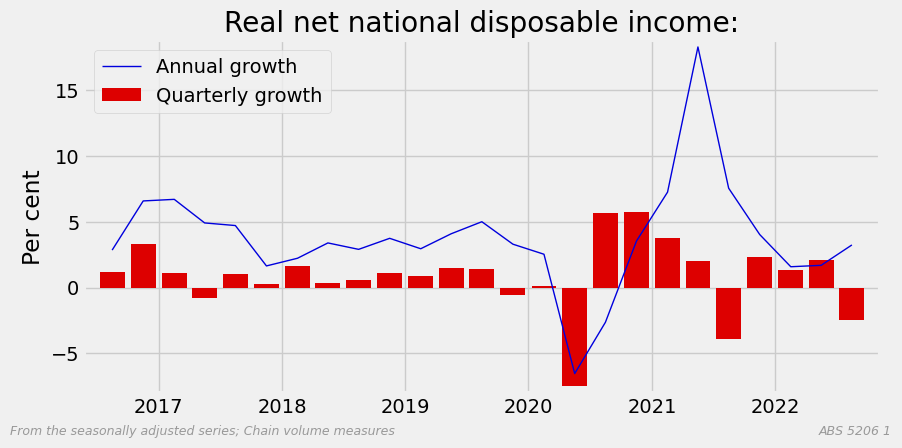

In [5]:
# identify available headline series from metadata
table = '1'
data = abs_dict[table]

series_type = 'Seasonally Adjusted'
headline_plots = meta[
    (meta[table_col] == table) &
    (meta[type_col] == series_type) &
    (meta[unit_col] == value_text) &
    (meta[did_col].str.contains(CVM))    
][did_col]

for description in headline_plots:
    
    # identify data
    series, units = get_identifier(meta, description,
                               series_type, table) 
    units = units + ' / Quarter' # make this clear
    plt_data, units = recalibrate_series(data[series], units)
    
    # plot
    for plot_from, plot_tag in zip(plot_times, plot_tags):

        title = description.replace(';', '').replace(CVM, '').strip()
        print(title)
        
        # plot raw quarterly data
        plot_data = plt_data
        if plot_from:
            plot_data = plt_data[plt_data.index >= plot_from]
        ax = plot_data.plot(lw=2, color="#dd0000")
        finalise_plot(ax, 
            title, units, plot_tag, CHART_DIR,
            rfooter=f'{source} {table}',
            lfooter=f'{series_type.lower()} series'
        )
        
        # plot quarterly and through the year growth
        plot_Qgrowth(data[series].copy(), 
                     title, plot_from, 
                     plot_tag, CHART_DIR,
                     rfooter=f'{source} {table}',
                     lfooter=f'From the {series_type.lower()} series; {CVM}',
                     show=True,
                    )

### Long run annual GDP Growth - using a Henderson moving average

In [6]:
def chart_gdp_long_run_growth(chart: str) -> None:
    
    # key data sources
    table = '1'
    data = abs_dict[table]
    series_type = 'Seasonally Adjusted'

    # select series
    selector = {
        table: table_col,
        chart: did_col,
        series_type: type_col,
        CVM: did_col,
        '$': unit_col,
    }
    id, units = find_id(meta, selector, verbose=False)

    # plot original
    ax = None # so we can comment out a plot code-line
    q_gdp = data[id]
    series = (q_gdp.pct_change(periods=4, fill_method=None) * 100).dropna()
    ax = series.plot(color='darkblue', lw=0.5, ls='-', ax=ax, label='Annual growth')
    
    # plot Henderson Moving Average
    HENDERSON_N = 13 # multi-year Henderson moving average
    smoothed = HMA(series, HENDERSON_N)
    ax = smoothed.plot(color='darkorange', lw=1.5, ls='-', ax=ax,
                     label=f'{HENDERSON_N}-term Henderson MA')

    # plot decadal averages
    decades = series.index.year.astype(str).str[2:3].unique()
    label = 'Decadal mean (DM) annual growth'
    for decade in decades:
        d_series = series[series.index.year.astype(str).str[2:3] == decade]
        d_series = pd.Series(np.repeat(d_series.mean(), len(d_series)), index=d_series.index)
        ax = d_series.plot(color='darkred', lw=2, ls='--', ax=ax, label=label)
        label = None
        ax.text(x=d_series.index[-1], y=series.min(), s=f'DM = {d_series.iloc[-1]:0.2f}%',
                rotation=90, ha='center', size='x-small')
        
    # plot compound annual growth rate over a decade
    YEARS = 10
    PERIODS_PER_YEAR = 4
    annual = (((q_gdp / q_gdp.shift(YEARS * PERIODS_PER_YEAR)) ** (1/YEARS)) - 1) * 100
    ax = annual.plot(color='dodgerblue', lw=3, ls='-', ax=ax,
                     label='Annual compound growth over decade')
        
    # finalise the plot
    ax.legend(loc='best', prop={'size': 'x-small'})
    ax.axhline(0, c='#999999', lw=0.75)
    title = f'YoY Growth - {chart} - Long-run trends'
    finalise_plot(ax, 
                  title, 
                  'Per cent', 
                  '', # tag 
                  CHART_DIR,
                  rfooter=f'{source} {table}',
                  lfooter=f'Australia. {series_type.capitalize()}. '
                          f'{CVM}. Compared with the same quarter in the previous year.',
                  #show=True,
    )

In [7]:
charts = [
    'Gross domestic product',
    'GDP per capita',
]
for chart in charts:
    chart_gdp_long_run_growth(chart)

### Four quarter rolling totals - original series

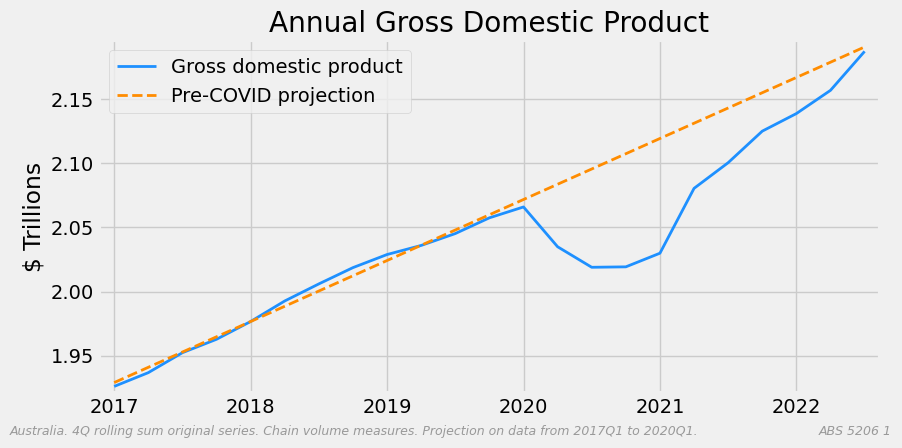

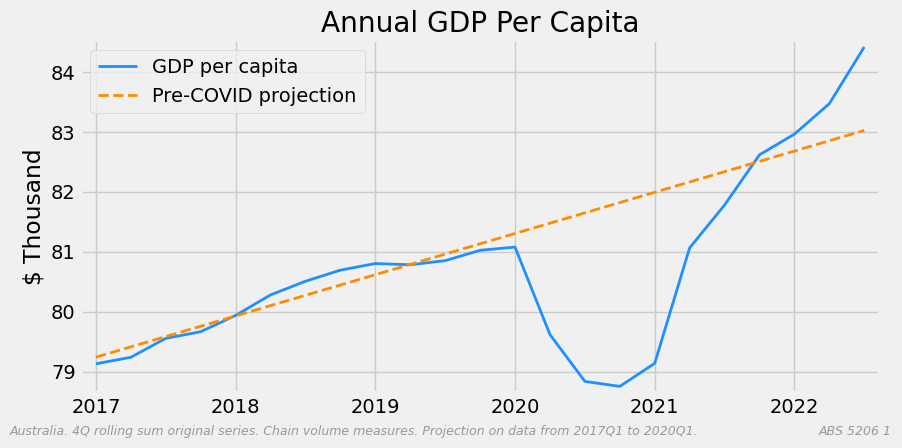

In [8]:
table = '1'
data = abs_dict[table]
series_type = "Original"

charts = [
    'Gross domestic product',
    'GDP per capita',
]
for chart in charts:
    selector = {
        table: table_col,
        chart: did_col,
        series_type: type_col,
        CVM: did_col,
        '$': unit_col,
    }
    id, units = find_id(meta, selector, verbose=False)
    rolling4Q = data[id].rolling(4).sum()
    rolling4Q.index = rolling4Q.index.to_period(freq='Q')
    units = '$ Number' if units == '$' else units
    rolling4Q, units = recalibrate_series(rolling4Q, units)
    rolling4Q.name = chart
    
    title = f'Annual {chart}'.title().replace('Gdp', 'GDP')
    plot_covid_recovery(
        rolling4Q, 
        title, 
        f'{units}', 
        '-recent-covid', CHART_DIR,
        rfooter=f'{source} {table}',
        lfooter=f'Australia. 4Q rolling sum {series_type.lower()} series. {CVM}. ',
        show=True,
    )  

### Savings

In [9]:
for table in ['1', '11']:

    table = '11'
    data = abs_dict[table]

    series_type = 'Seasonally Adjusted'
    headline_plots = meta[
        (meta['Table'] == table) &
        (meta['Series Type'] == series_type) &
        (meta['Data Item Description'].str.contains("saving"))    
    ]['Data Item Description']

    for description in headline_plots:
        # identify data
        series, units = get_identifier(meta, description,
                               series_type, table) 
        units = units + ' / Quarter'
        plotable, units = recalibrate_series(data[series], units)
    
        for plot_from, plot_tag in zip(plot_times, plot_tags):

            title = description.replace(' ;', '')
        
            # plot raw quarterly data
            plot_data = plotable
            if plot_from:
                plot_data = plotable[plotable.index >= plot_from]
            ax = plot_data.plot(lw=2, color="#dd0000")
            finalise_plot(ax, 
                title, units, plot_tag, CHART_DIR,
                rfooter=f'{source} {table}',
                lfooter=f'{series_type.lower()} series',
                          #show=True,
            )

### Gross Value Added (GVA) by Industry

In [10]:
# identify available series from metadata
table = '6'
data = abs_dict[table]

series_type = 'Seasonally Adjusted'
industries = meta[
    (meta[table_col] == table) &
    (meta[type_col] == series_type) &
    (meta[unit_col] == value_text) # limit to money
][did_col]
industry_start = pd.Timestamp('1974-09-01')

for industry in industries:

    # get data
    selector = {
        table: table_col,
        series_type: type_col,
        industry: did_col,
    }
    
    series, units = find_id(meta, selector, exact=True, verbose=False)
    units = f'{units}  / Quarter'
    plotable, units = recalibrate_series(data[series], units)

    # plot
    for start, tag in zip(plot_times, plot_tags):
        subset = plotable[plotable.index >= start] if start else plotable
        subset = subset[subset.index >= industry_start]
        ax = subset.plot(lw=2, color="#dd0000")

        # we limit subgroup titles to keep the width
        # within what would fit on the top of a plot
        title = industry.replace(' ;', '').strip()
        if not title.endswith(")"):
            title = re.sub("^[^\(]+\(", "(", title)
        title = f' GVA: {title}'

        finalise_plot(ax, title, units, tag, CHART_DIR,
            rfooter=f'{source} {table}',
            lfooter=(f'{series_type.capitalize()}, '
                     f'{CVM.lower()}'),
            #show=True
        )

###  Household Final Consumption Expenditure

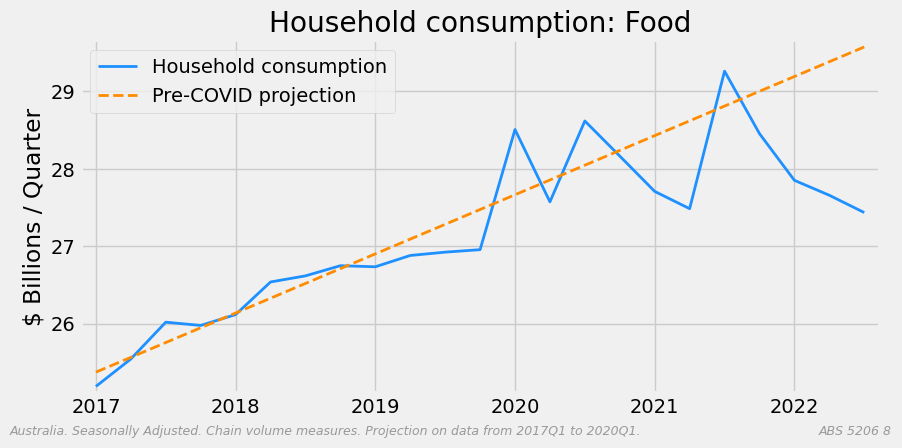

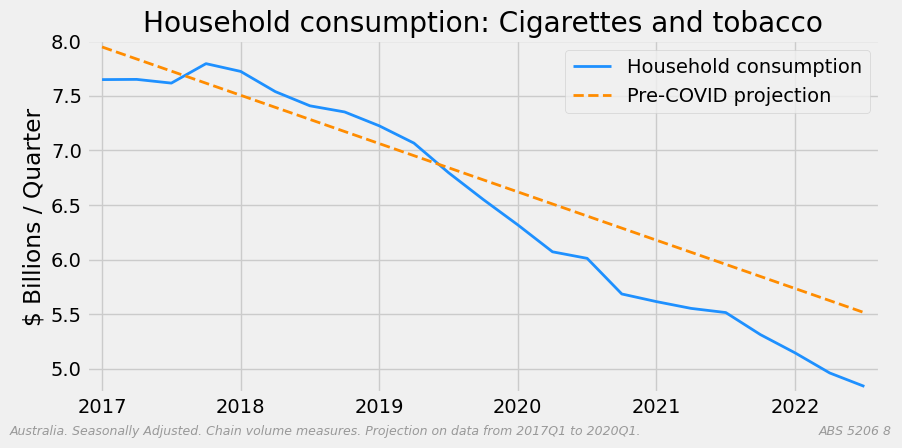

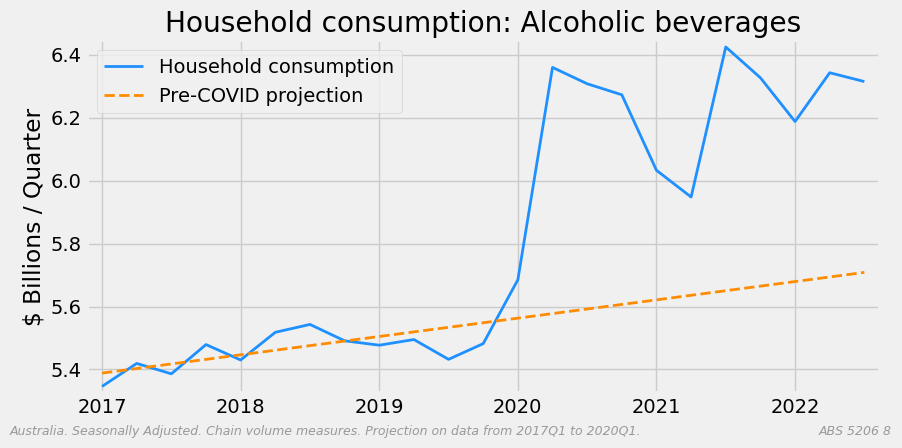

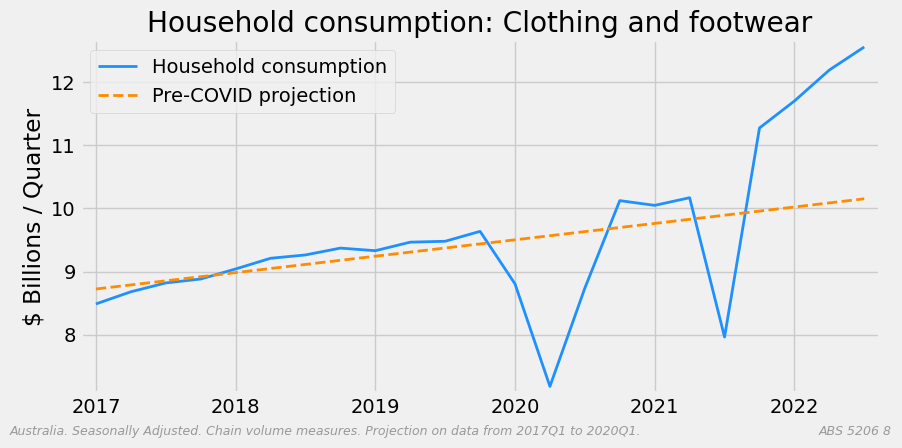

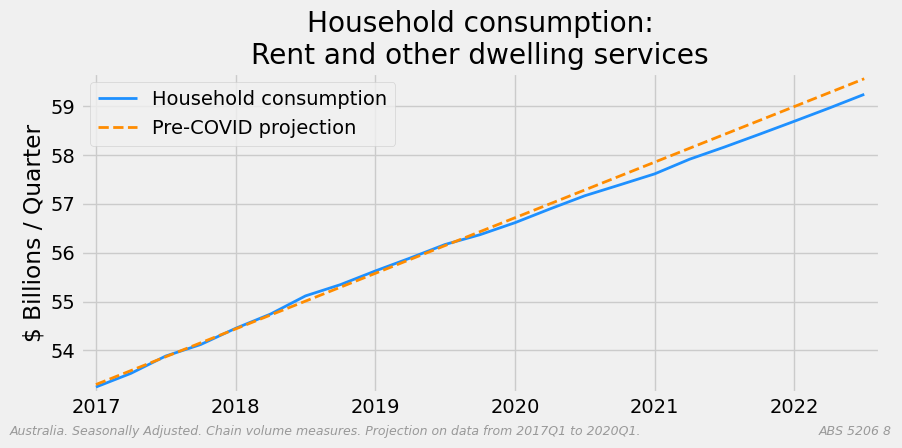

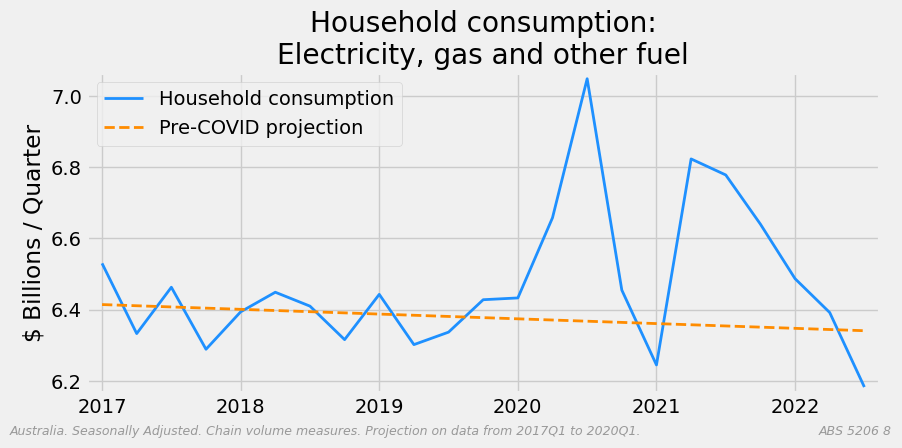

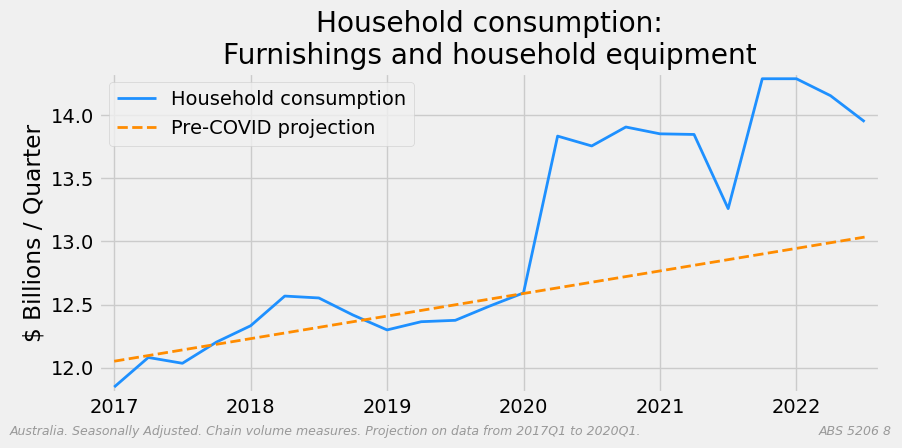

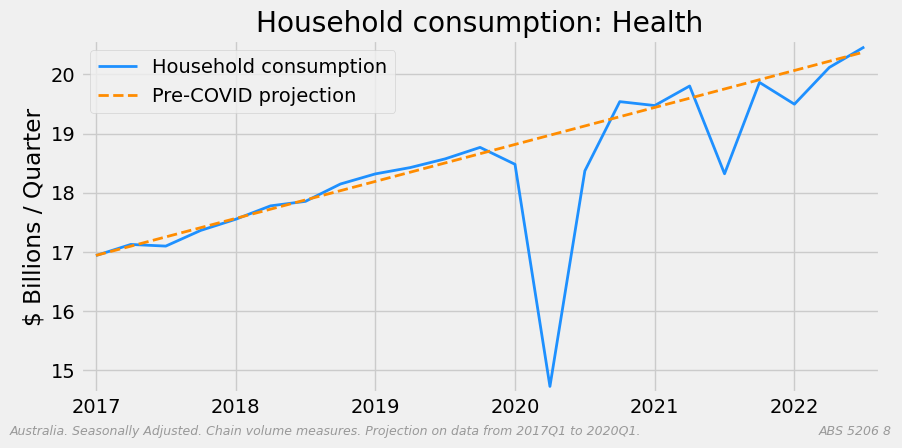

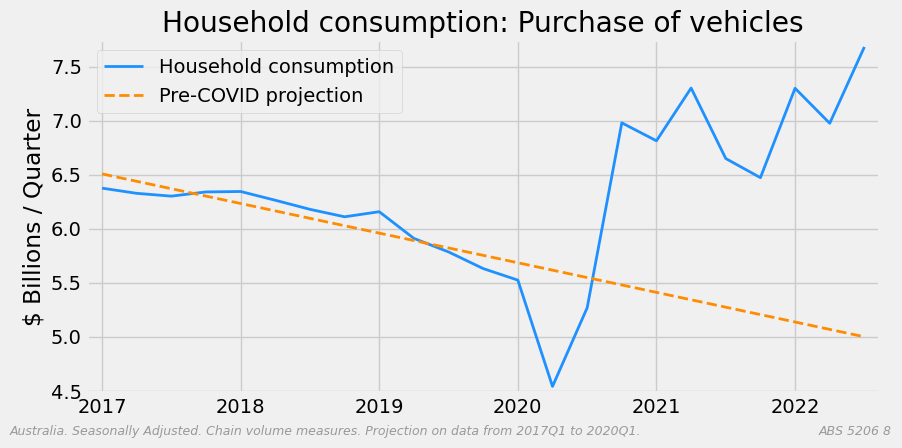

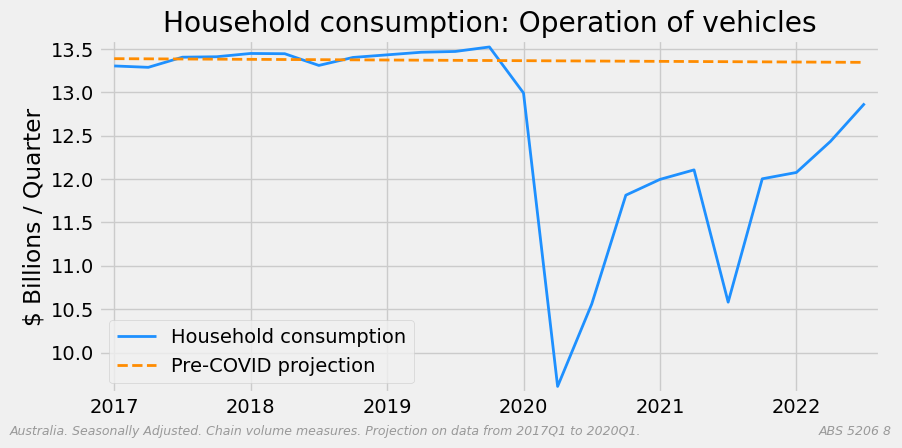

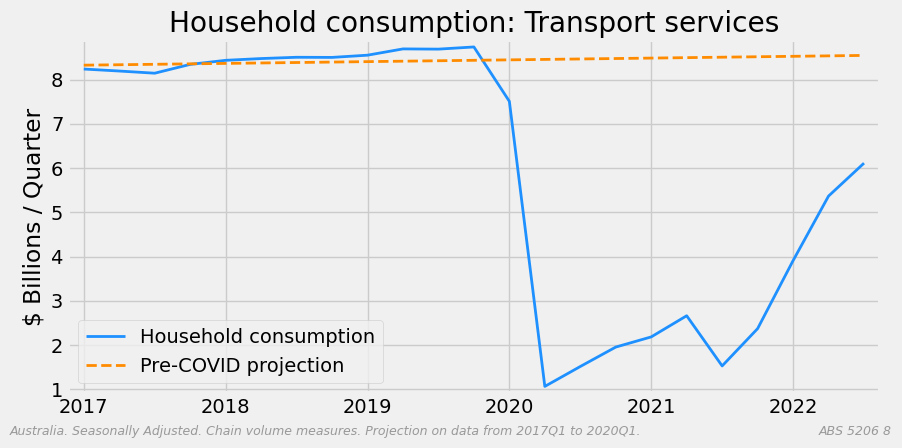

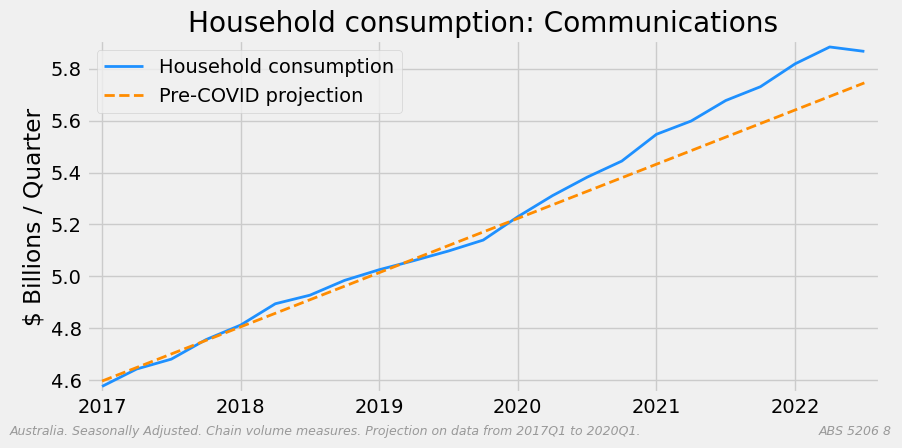

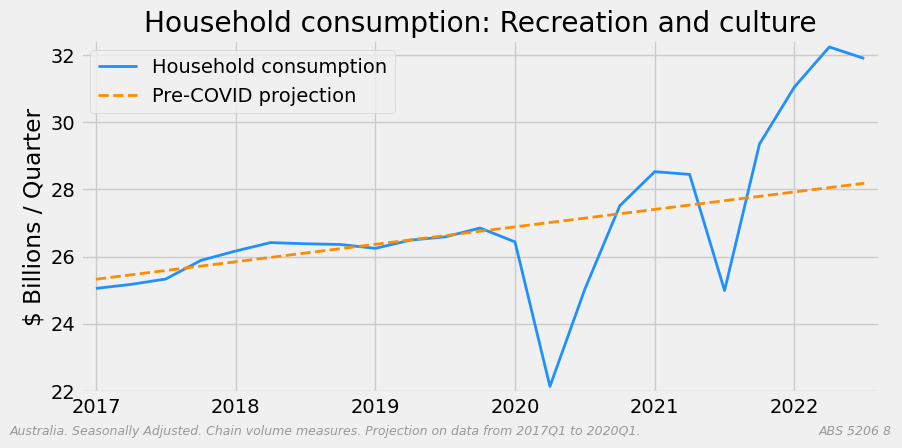

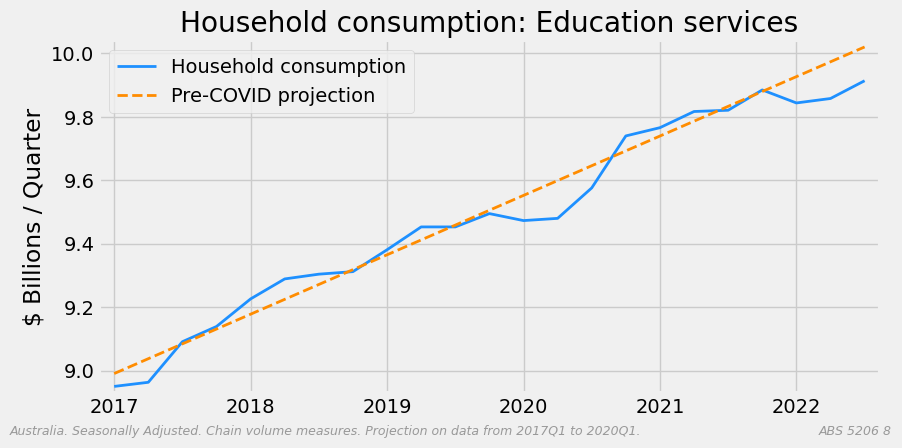

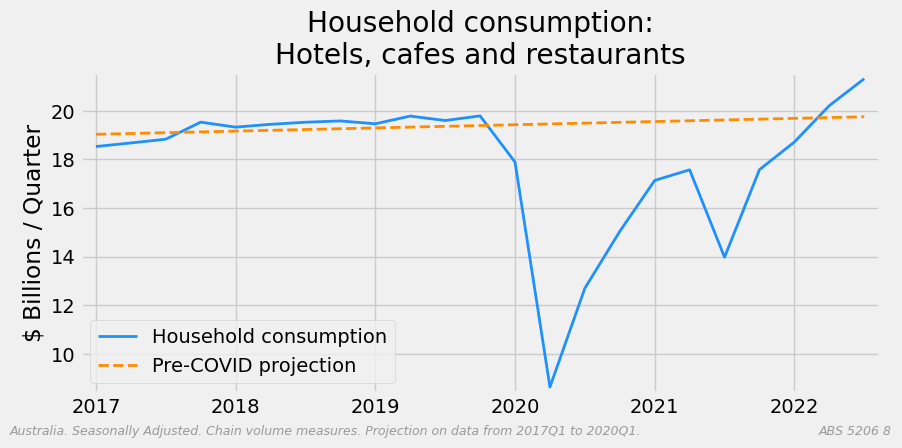

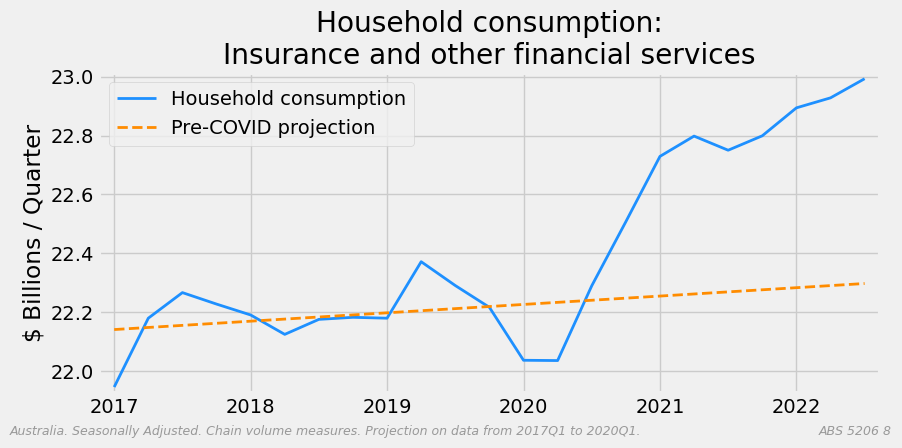

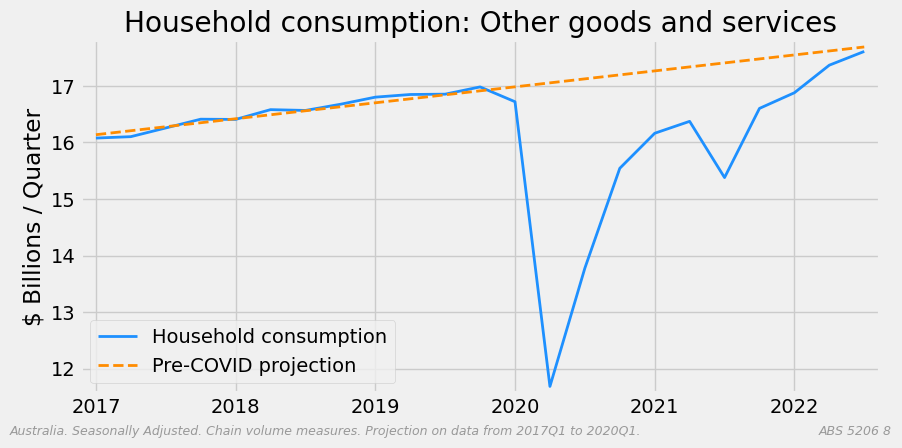

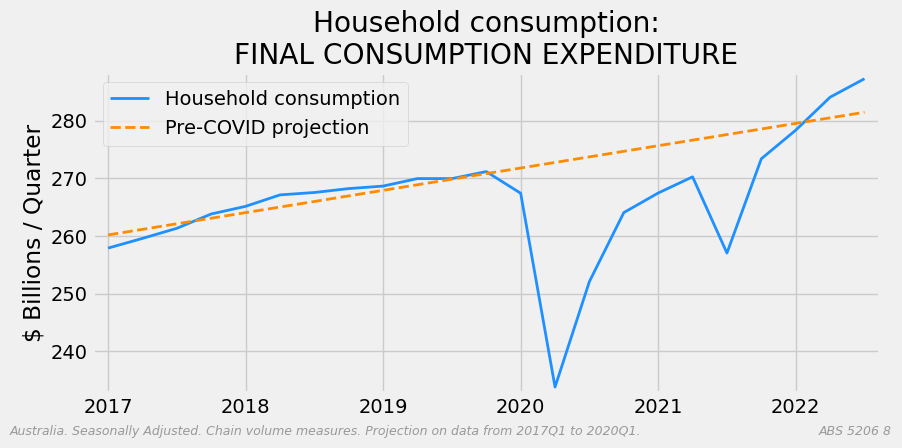

In [19]:
# identify available series from metadata
table = '8'
data = abs_dict[table]
series_type = 'Seasonally Adjusted'
hfce = meta[
    (meta['Table'] == table) &
    (meta['Series Type'] == series_type) &
    (meta['Unit'] == '$ Millions') & # limit to money
    (meta['Data Item Description'].str.contains(CVM))
]['Data Item Description']

for description in hfce:
    
    # get data
    series, units = get_identifier(meta, description,
                                   series_type, table)
    units = f'{units} / Quarter'
    plotable, units = recalibrate_series(data[series], units)
    plotable.index = plotable.index.to_period(freq='Q')
    plotable.name = 'Household consumption'
    title = description.replace(f': {CVM} ;', '')
    separator = '\n' if len(title) > 25 else ' '
    title = f'Household consumption:{separator}{title}'

    # plot - complete series - and recent showing covid recoverhy
    ax = plotable.plot(lw=2, color="#dd0000")
    finalise_plot(ax, title, units, '', CHART_DIR,
        rfooter=f'{source} {table}',
        lfooter=(f'{series_type.capitalize()}, '
                 f'{CVM.lower()}'),
        #show=True
    )
    
    plot_covid_recovery(
        plotable, 
        title, 
        units, 
        '-recent-covid', CHART_DIR,
        rfooter=f'{source} {table}',
        lfooter=f'Australia. {series_type}. {CVM}. ',
        #show=True,
    )      
    


### Taxes

In [12]:
# identify available series from metadata
table = '22'
data = abs_dict[table]
series_type = 'Seasonally Adjusted'
tax_plots = meta[
    (meta['Table'] == table) &
    (meta['Series Type'] == series_type) 
]['Data Item Description']

for plot in tax_plots:
    
    # data capture
    ident, units = get_identifier(meta, plot, series_type, table)
    units = f'{units} / Qtr'
    series = data[ident]
    
    series, units = recalibrate_series(series, units)
    
    series = series[series.index >= RECENT]
    if series.isna().all():
        # don't plot empty series
        continue
    
    # plot
    ax = series.plot(lw=2, color="#dd0000")
    title = plot.replace(' ;', '')
    finalise_plot(ax, title, 
                  f'{units} (Current Prices)', 
                  'govt-tax', CHART_DIR,
                  rfooter=f'{source} {table}',
                  lfooter=f'{series_type.capitalize()} series',
                  #show=True,
                 )

### Government Benefits Payments

In [13]:
table = '23'
data = abs_dict[table]
series_type = 'Original'
plots_payments = meta[
    (meta['Table'] == table) &
    (meta['Series Type'] == series_type) 
]['Data Item Description']

for plot in plots_payments:
    
    # get data
    ident, units = get_identifier(meta, plot, series_type, table)
    units = f'{units} / Qtr'
    series = data[ident]
    
    series, units = recalibrate_series(series, units)
    
    series = series[series.index >= RECENT]
    if series.isna().all():
        # don't plot empty series
        continue

    # plot
    ax = series.plot(lw=2, color="#dd0000")
    
    # - from ABS description to plot title
    title = plot.replace('General government - National ;  ',
                         'Federal Govt - ')
    title = title.replace('General government - State and local ;  ',
                         'State or Local Govt - ')
    title = title.replace('General government ;  ',
                         'All Govt - ')
    title = title.replace(' ;', '')
    
    finalise_plot(ax, title, f'{units} (Current Prices)', 
                  'govt-spending', CHART_DIR,
                  rfooter=f'{source} {table}',
                  lfooter=f'{series_type.capitalize()} series')
        

### Implicit price deflators

In [14]:
table = '5'
data = abs_dict[table]

keys = {
    'GDP': 'GROSS DOMESTIC PRODUCT ;',
    'HFCE': 'Households ;  Final consumption expenditure ;',
}

for prefix, key in keys.items():
    ident = meta[(meta['Data Item Description'] == key)
     & (meta['Table'] == table)]['Series ID']
    
    series1 = data[ident].pct_change(4).mul(100).dropna()
    series2 = series1.rolling(4).mean()
    series_set = (series1, series2)
    tags = ('', '(4-term moving average)')

    for series, tag in zip(series_set, tags):
        ax = series.plot(lw=2, color="#dd0000")
        ax.get_legend().remove()
        title = f'{prefix} Implicit Price Deflator {tag}'
        finalise_plot(ax, title, 'Per cent per annum', 
                      '', 
                      CHART_DIR,
                      rfooter=f'{source} {table}',
                      lfooter='Calculated from Seasonally Adjusted index',
                      #show=True,
                     )

## Save nominal GDP (it is useful elsewhere)

In [15]:
NOMINAL_GDP_DIR = "./DATA/"
pathlib.Path(NOMINAL_GDP_DIR).mkdir(parents=True, exist_ok=True)
NOMINAL_GDP_CSV = NOMINAL_GDP_DIR + 'nominal_gdp.csv'

table = '24' # Selected Analytical Series
data = abs_dict[table]
series_type = 'Original'
descriptions = [
    'Non-farm ;  Gross domestic product: Current prices ;',
    'Farm ;  Gross domestic product: Current prices ;',
]
frame = {}
for series in descriptions:
    ident, units = get_identifier(meta, series, series_type, table)
    frame[series] = data[ident]
print(f'From table {table}: {units}')
frame = pd.DataFrame(frame)
frame['Total quarterly'] = frame.sum(axis=1)
frame['Rolling Annual'] = frame['Total quarterly'].rolling(4).sum()

table = '34' # Key Aggregates and analytical series, Annual
data = abs_dict[table]
series = 'Gross domestic product: Current prices ;'
ident, units = get_identifier(meta, series, series_type, table)
print(f'From table {table}: {units}')
frame[f'Annual {series}'] =  data[ident]

frame.to_csv(NOMINAL_GDP_CSV)

From table 24: $ Millions
From table 34: $ Millions


## Finished

In [16]:
# watermark
%load_ext watermark
%watermark -u -n -t -v -iv -w

Last updated: Sun Feb 05 2023 18:48:03

Python implementation: CPython
Python version       : 3.10.9
IPython version      : 8.7.0

matplotlib: 3.6.3
pandas    : 1.5.3
numpy     : 1.24.1
re        : 2.2.1

Watermark: 2.3.1



In [17]:
print('Finished')

Finished
